In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

corr = pd.read_hdf("../data/seqsim_f_all.h5")
meta = pd.read_csv("../data/sources/ArchiveII_with_prob_and_motiv.csv")

In [8]:
# --- 2. Conjuntos de IDs ---------------------------------------------------
meta_ids = set(meta["id"])
corr_ids = set(corr.index)  # lo mismo para columnas

# --- 3. Diagnóstico rápido -------------------------------------------------
missing_in_meta = corr_ids - meta_ids  # filas/cols que sobran en corr
missing_in_corr = meta_ids - corr_ids  # registros de meta sin correlación

print(f"⚠️  {len(missing_in_meta)} IDs en 'corr' no existen en 'meta'")
print(f"⚠️  {len(missing_in_corr)} IDs en 'meta' no aparecen en 'corr'")

# --- 4. Sub-muestra “limpia” ----------------------------------------------
common_ids = sorted(meta_ids & corr_ids)  # intersección ordenada por nombre

corr_clean = corr.loc[common_ids, common_ids]  # filtrar filas y columnas
meta_clean = meta[meta["id"].isin(common_ids)].copy()  # filtrar meta
meta_clean = meta_clean.set_index("id").loc[common_ids]  # re-ordenar

# --- 5. (Opcional) guardar o seguir trabajando -----------------------------
# corr_clean.to_csv("corr_filtered.csv")
# meta_clean.to_csv("meta_filtered.csv")

print("✅  Matriz y metadatos alineados:", corr_clean.shape, meta_clean.shape)

⚠️  111 IDs en 'corr' no existen en 'meta'
⚠️  0 IDs en 'meta' no aparecen en 'corr'
✅  Matriz y metadatos alineados: (3864, 3864) (3864, 8)


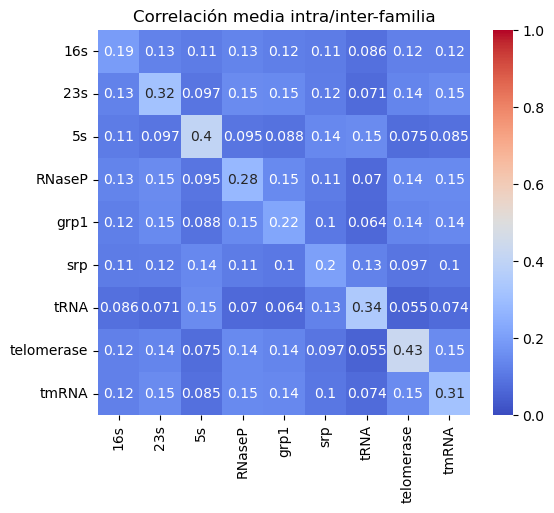

In [11]:
# Vector con la familia de cada fila/columna en el mismo orden que corr_clean
fam_vec = meta_clean["fam"].values
fams = np.unique(fam_vec)

# Pre-asignamos matriz (n_fam × n_fam)
fam_corr = pd.DataFrame(index=fams, columns=fams, dtype=float)

# Creamos un diccionario {fam: índices}
idx_by_fam = {f: np.where(fam_vec == f)[0] for f in fams}

for f1 in fams:
    for f2 in fams:
        # tomamos todas las correlaciones (sub-matriz) entre las dos familias
        sub = corr_clean.values[np.ix_(idx_by_fam[f1], idx_by_fam[f2])]
        fam_corr.loc[f1, f2] = sub.mean()
plt.figure(figsize=(6, 5))
sns.heatmap(fam_corr, annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title("Correlación media intra/inter-familia")
plt.show()

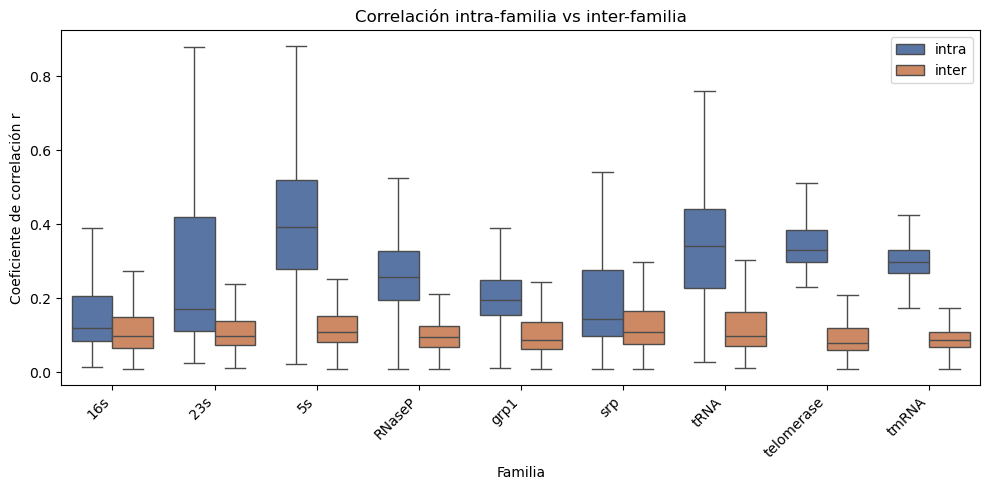

In [13]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ---------- 1. Convertimos `dist` a formato largo --------------------------

rows = []
for pair, r in zip(dist["pair"], dist["corr"]):
    if pair.startswith("intra "):
        fam = pair.split(maxsplit=1)[1]
        rows.append({"fam": fam, "kind": "intra", "corr": r})
    else:  # formato "5s vs tRNA"
        f1, f2 = pair.split(" vs ")
        rows.append({"fam": f1, "kind": "inter", "corr": r})
        rows.append({"fam": f2, "kind": "inter", "corr": r})

dist_long = pd.DataFrame(rows)

# ---------- 2. Boxplot con seaborn ----------------------------------------

plt.figure(figsize=(10, 5))
sns.boxplot(
    data=dist_long,
    x="fam",
    y="corr",
    hue="kind",
    showfliers=False,
    palette={"intra": "#4C72B0", "inter": "#DD8452"},
)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Familia")
plt.ylabel("Coeficiente de correlación r")
plt.title("Correlación intra-familia vs inter-familia")
plt.legend(title="")
plt.tight_layout()
plt.show()

In [14]:
# ------------------------------------------------------------------
# 0. Precondición
#   • corr_clean : DataFrame cuadrado, índices = columnas = IDs
#   • meta_clean : DataFrame con índice = IDs y columna 'fam'
# ------------------------------------------------------------------

import pandas as pd

# 1. Agrupar los índices por familia
idx_by_fam = meta_clean.groupby("fam").groups  # dict  fam → list(ids)

# 2. Construir el diccionario de matrices
corrs = {}
for fam, ids in idx_by_fam.items():
    # extrae filas y columnas correspondientes a esa familia
    corrs[fam] = corr_clean.loc[ids, ids].copy()

# 3. Diagnóstico rápido
for fam, mat in corrs.items():
    print(f"{fam:10s}  {mat.shape[0]:>4d} × {mat.shape[1]:<4d}")

16s           66 × 66  
23s           15 × 15  
5s          1283 × 1283
RNaseP       454 × 454 
grp1          74 × 74  
srp          918 × 918 
tRNA         557 × 557 
telomerase    35 × 35  
tmRNA        462 × 462 


In [15]:
import numpy as np
import pandas as pd

# ------------------------------------------------------------------
# Precondición
#   corr_clean : DataFrame cuadrado, índices = columnas = IDs
#   meta_clean : DataFrame con índice = IDs y columna 'fam'
# ------------------------------------------------------------------

# 1) Agrupar IDs por familia
idx_by_fam = meta_clean.groupby("fam").groups  # dict fam → list(ids)

# 2) Diccionario de sub-matrices
corrs = {fam: corr_clean.loc[ids, ids].copy() for fam, ids in idx_by_fam.items()}

# 3) Resumen numérico rápido
rows = []
for fam, mat in corrs.items():
    # quitamos diagonal para estadística interna
    tri_vals = mat.values[np.triu_indices_from(mat, k=1)]
    rows.append(
        {
            "fam": fam,
            "n_seq": mat.shape[0],
            "min_r": tri_vals.min() if tri_vals.size else np.nan,
            "mean_r": tri_vals.mean() if tri_vals.size else np.nan,
            "max_r": tri_vals.max() if tri_vals.size else np.nan,
        }
    )

summary = (
    pd.DataFrame(rows).sort_values("n_seq", ascending=False).reset_index(drop=True)
)

display(summary)  # en Jupyter muestra tabla bonita

fam  n_seq     min_r    mean_r     max_r
0          5s   1283  0.021459  0.403385  1.000000
1         srp    918  0.010165  0.203762  1.000000
2        tRNA    557  0.027778  0.343584  1.000000
3       tmRNA    462  0.012690  0.312829  1.000000
4      RNaseP    454  0.010072  0.276572  1.000000
5        grp1     74  0.010703  0.208144  1.000000
6         16s     66  0.015528  0.179238  0.867327
7  telomerase     35  0.230143  0.412466  0.984887
8         23s     15  0.023723  0.266716  0.925287

In [17]:
import numpy as np
import pandas as pd
import networkx as nx


def filter_by_threshold(corrs: dict, threshold: float, min_seqs: int):
    """
    Filtra cada sub-matriz de distancias según:
        • distancia <= threshold   (más parecido ⇒ arista)
        • tamaño del componente conexo >= min_seqs
    Parámetros
    ----------
    corrs : dict
        {'fam': DataFrame (distancias)} – índices = columnas = IDs
    threshold : float
        Distancia máxima para considerar dos secuencias “similares”.
    min_seqs : int
        Número mínimo de secuencias que debe tener un cluster
        para conservarse.
    Devuelve
    --------
    corrs_filt : dict
        Diccionario con las nuevas sub-matrices filtradas.
    clusters_filt : dict
        {'fam': [set(ids), set(ids), ...]} solo clusters retenidos.
    """
    corrs_filt = {}
    clusters_filt = {}

    for fam, mat in corrs.items():
        ids = mat.index.to_list()
        # 1. Grafo: arista si distancia <= threshold
        G = nx.Graph()
        G.add_nodes_from(ids)

        tri_i, tri_j = np.triu_indices_from(mat, k=1)
        mask = mat.values[tri_i, tri_j] <= threshold
        edges = [(ids[i], ids[j]) for i, j in zip(tri_i[mask], tri_j[mask])]
        G.add_edges_from(edges)

        # 2. Componentes conexas
        comps = [c for c in nx.connected_components(G) if len(c) >= min_seqs]

        if not comps:  # nada que cumpla el criterio
            continue

        # 3. a) guardar clusters
        clusters_filt[fam] = comps

        #    b) IDs que pasan el filtro
        keep_ids = [sid for comp in comps for sid in comp]
        corrs_filt[fam] = mat.loc[keep_ids, keep_ids]

    return corrs_filt, clusters_filt

In [19]:
ordered_fams

['16s', 'srp', 'grp1', '23s', 'RNaseP', 'tmRNA', 'tRNA', '5s', 'telomerase']

Orden de familias:
  16s         media = 0.179
  srp         media = 0.204
  grp1        media = 0.208
  RNaseP      media = 0.277
  tmRNA       media = 0.313
  tRNA        media = 0.344
  5s          media = 0.403
  telomerase  media = 0.412


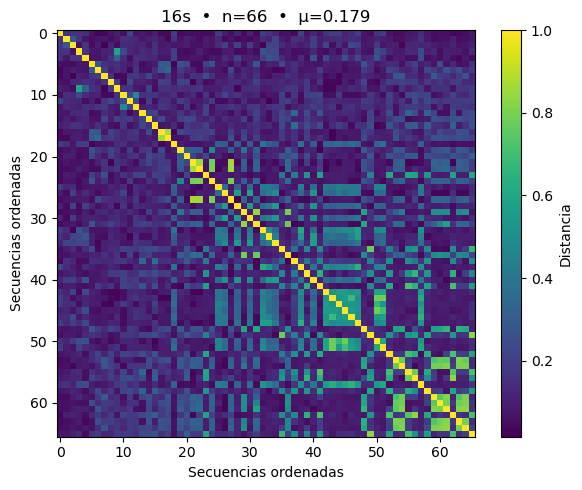

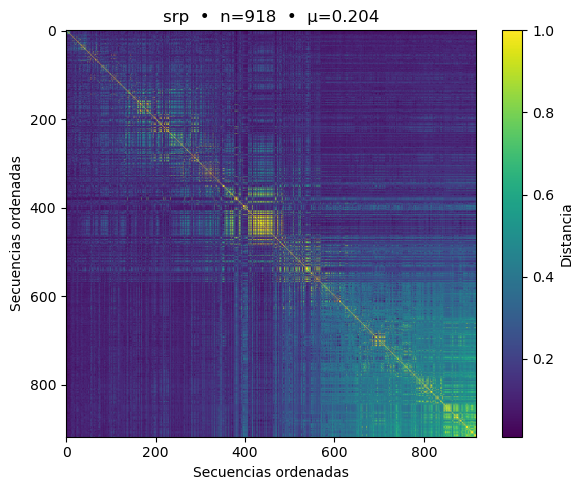

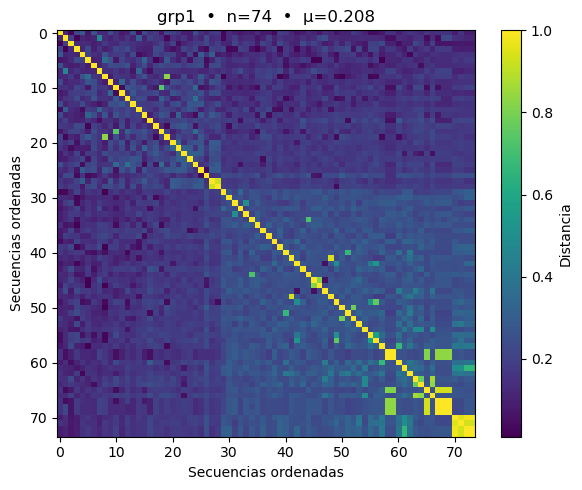

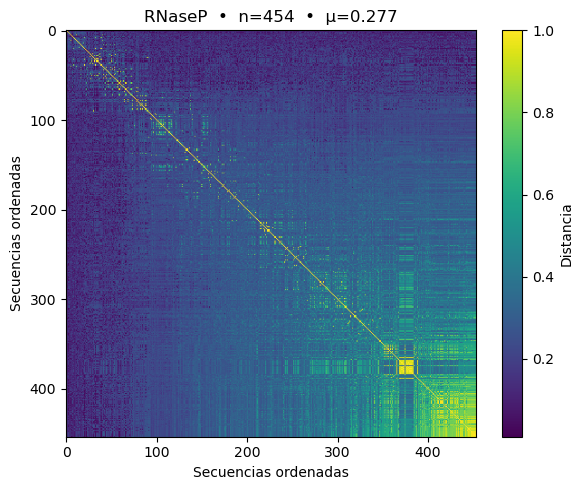

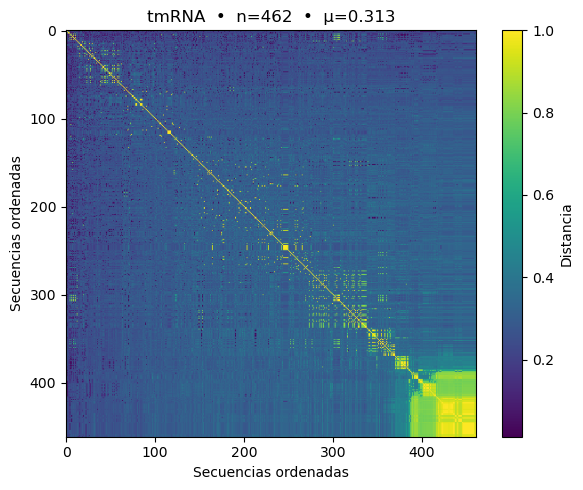

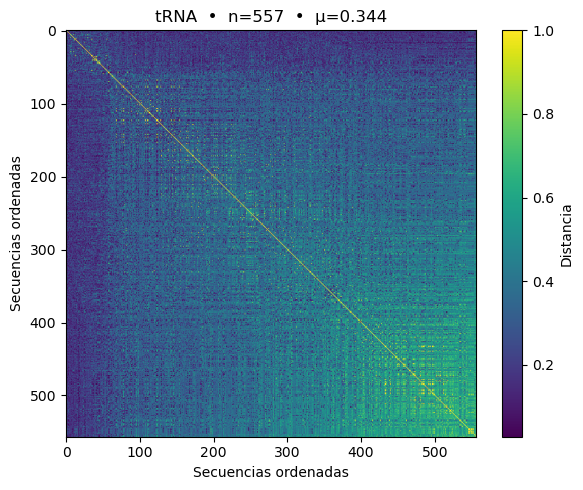

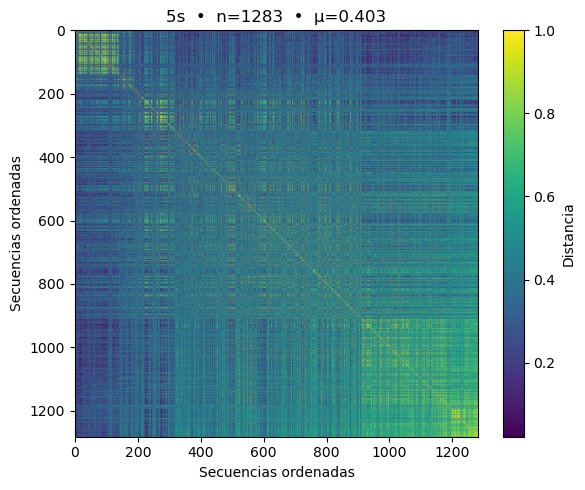

In [27]:
corrs_filt, clusters_filt = filter_by_threshold(corrs, threshold=1, min_seqs=30)

# partimos de `corrs_filt` (diccionario fam -> matriz de distancias)
fam_mean = {
    fam: mat.values[np.triu_indices_from(mat, k=1)].mean()
    for fam, mat in corrs_filt.items()
}

# Ascendente → del grupo más parecido (distancia ↓) al menos parecido
ordered_fams = sorted(fam_mean, key=fam_mean.get)

print("Orden de familias:")
for fam in ordered_fams:
    print(f"  {fam:10s}  media = {fam_mean[fam]:.3f}")


def order_by_mean_distance(mat):
    # media por fila → menor ⇒ más “central”
    avg = mat.mean(axis=1)
    ordered_ids = avg.sort_values().index
    return mat.loc[ordered_ids, ordered_ids]


import matplotlib.pyplot as plt

# cuántas familias quieres graficar (–1 → todas)
n_fams_plot = -1
for fam in ordered_fams[:n_fams_plot]:
    mat_orig = corrs_filt[fam]

    # --- elige una de las dos funciones de orden ------------
    # mat = order_by_clustering(mat_orig)
    mat = order_by_mean_distance(mat_orig)

    # --- heatmap --------------------------------------------
    plt.figure(figsize=(6, 5))
    plt.imshow(mat.values, aspect="auto", cmap="viridis")
    plt.colorbar(label="Distancia")
    plt.title(f"{fam}  •  n={mat.shape[0]}  •  μ={fam_mean[fam]:.3f}")
    plt.xlabel("Secuencias ordenadas")
    plt.ylabel("Secuencias ordenadas")
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_2227028/3910422142.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.96, 0.9])  # margen dcho p/ colorbar


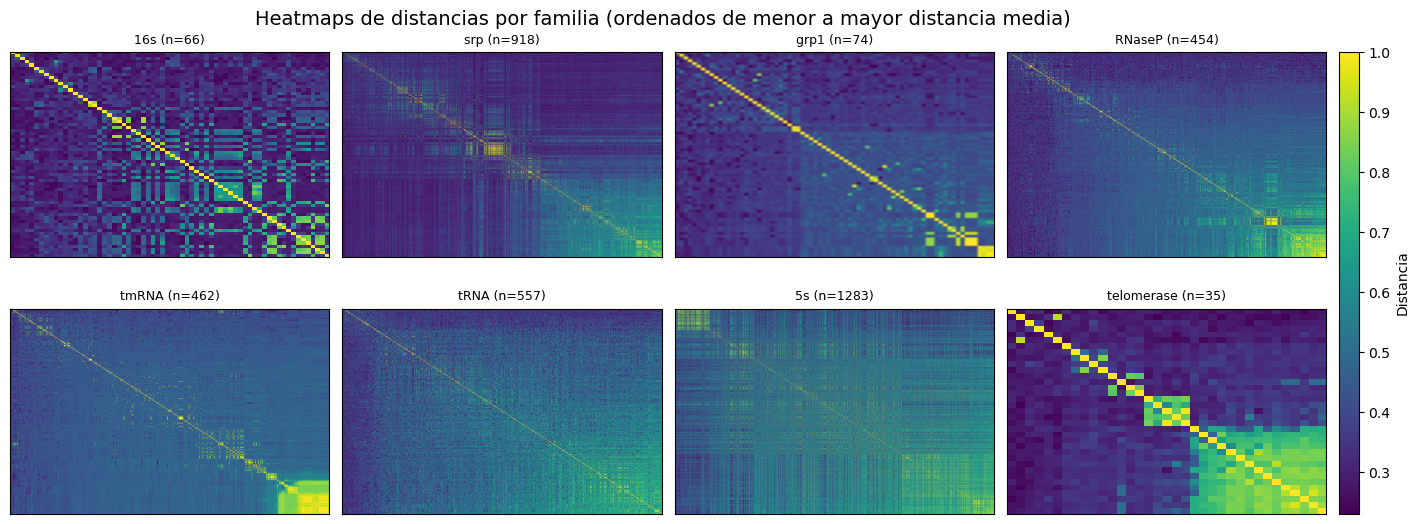

In [53]:
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# -----------------------------------------------------------------
# PRE-REQUISITOS
#   • ordered_fams   → lista de familias ordenadas por distancia media
#   • corrs_filt     → dict  {fam: DataFrame de distancias}
#   • order_by_mean_distance(mat) → función que re-acomoda filas/columnas
# -----------------------------------------------------------------

# 1) Queremos las 8 primeras familias
n_fams = min(8, len(ordered_fams))
plot_fams = ordered_fams[:n_fams]

# 2) Grid de 4 columnas × 2 filas  (+ 1 columna angosta para la barra)
n_cols = 4
n_rows = 2

fig = plt.figure(figsize=(4 * n_cols + 1.4, 3 * n_rows))
gs = gridspec.GridSpec(
    n_rows,
    n_cols + 1,  # última col = colorbar
    width_ratios=[1] * n_cols + [0.06],
    wspace=0.05,
    hspace=0.25,
)

last_im = None
for idx, fam in enumerate(plot_fams):
    ax = fig.add_subplot(gs[idx // n_cols, idx % n_cols])

    mat = order_by_mean_distance(corrs_filt[fam])
    last_im = ax.imshow(mat.values, aspect="auto", cmap="viridis")

    ax.set_title(f"{fam} (n={mat.shape[0]})", fontsize=9)
    ax.set_xticks([])
    ax.set_yticks([])

# 3) Si sobran casillas (p.ej. <8 familias reales), las ocultamos
for idx in range(len(plot_fams), n_rows * n_cols):
    fig.add_subplot(gs[idx // n_cols, idx % n_cols]).axis("off")

# 4) Barra de color
cax = fig.add_subplot(gs[:, -1])
fig.colorbar(last_im, cax=cax, label="Distancia")

fig.suptitle(
    "Heatmaps de distancias por familia (ordenados de menor a mayor distancia media)",
    y=0.95,
    fontsize=14,
)
plt.tight_layout(rect=[0, 0, 0.96, 0.9])  # margen dcho p/ colorbar
plt.show()

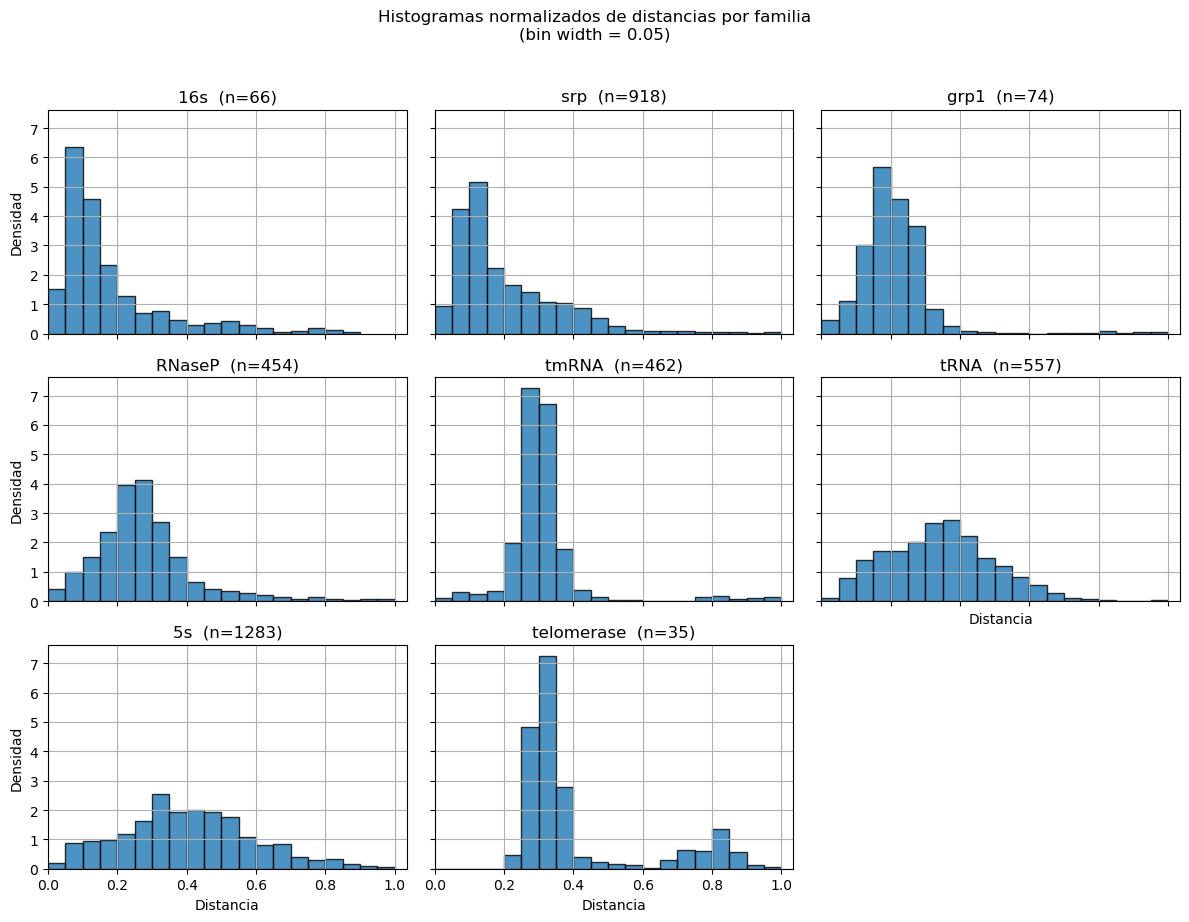

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import math

# ------------------------------------------------------------------
# Este bloque asume que ya existen:
#   • corrs_filt  : dict  {fam: DataFrame de distancias}
# ------------------------------------------------------------------

# A. Ordenar familias por distancia media (más compactas primero)
fam_mean = {
    fam: mat.values[np.triu_indices_from(mat, k=1)].mean()
    for fam, mat in corrs_filt.items()
}
ordered_fams = sorted(fam_mean, key=fam_mean.get)

# B. Parámetros de los histogramas
bin_width = 0.05

# C. Layout de subplots
n_fams = len(ordered_fams)
n_cols = 3
n_rows = math.ceil(n_fams / n_cols)

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(n_cols * 4, n_rows * 3),
    squeeze=False,
    sharex=True,
    sharey=True,
)

for idx, fam in enumerate(ordered_fams):
    ax = axes[idx // n_cols, idx % n_cols]
    mat = corrs_filt[fam]

    # Triángulo superior sin diagonal
    dists = mat.values[np.triu_indices_from(mat, k=1)]
    if dists.size == 0:
        ax.text(0.5, 0.5, "No data", ha="center", va="center")
        ax.set_axis_off()
        continue

    # Bins dinámicos según máximo
    max_val = dists.max()
    bins = np.arange(0, max_val + bin_width, bin_width)

    ax.hist(dists, bins=bins, density=True, alpha=0.8, edgecolor="black")
    ax.set_title(f"{fam}  (n={mat.shape[0]})")
    ax.grid()
    ax.set_xlim(0, max_val + bin_width)

for i in range(3):
    axes[i, 0].set_ylabel("Densidad")

for i in range(3):
    axes[2, i].set_xlabel("Distancia")
axes[1, 2].set_xlabel("Distancia")
# Elimina paneles vacíos si sobran
for j in range(idx + 1, n_rows * n_cols):
    axes[j // n_cols, j % n_cols].set_axis_off()

fig.suptitle(
    "Histogramas normalizados de distancias por familia\n(bin width = 0.05)", y=1.02
)
plt.tight_layout()
plt.show()

/tmp/ipykernel_2227028/790005938.py:45: UserWarning: Adding colorbar to a different Figure <Figure size 2140x1000 with 9 Axes> than <Figure size 2140x1000 with 9 Axes> which fig.colorbar is called on.
  fig.colorbar(last_im, cax=cax, label="Distancia")
/tmp/ipykernel_2227028/790005938.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.96, 0.90])


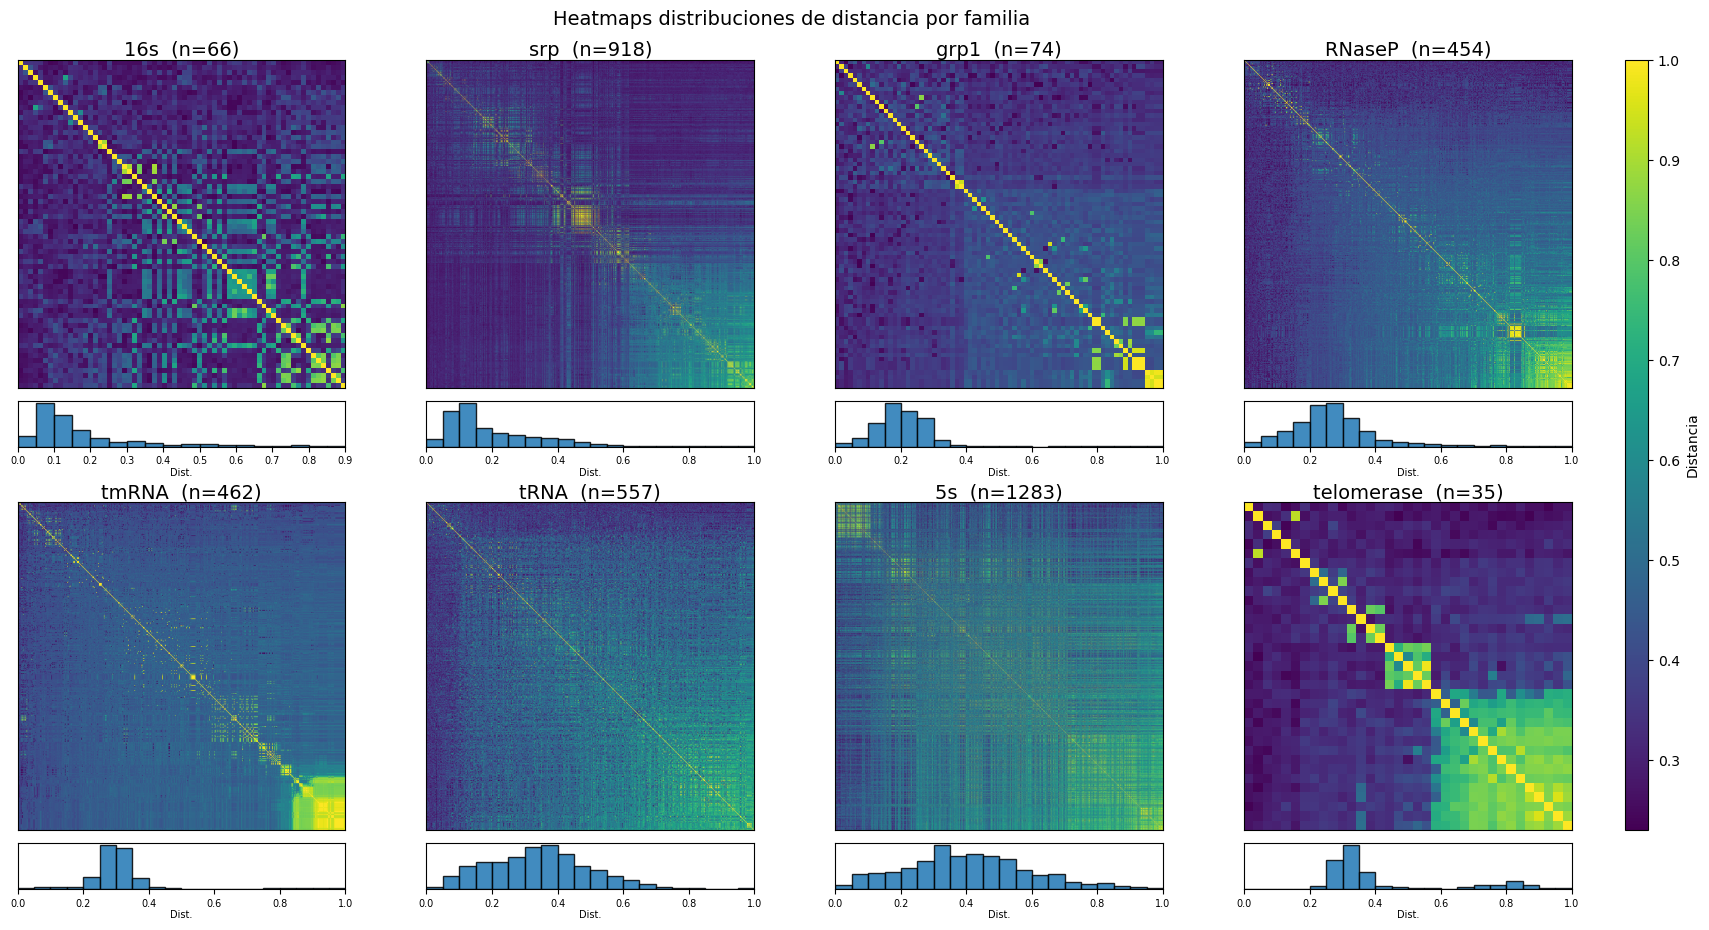

In [83]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

n_cols, n_rows = 4, 2
fig = plt.figure(figsize=(5 * n_cols + 1.4, 5 * n_rows))

gs = gridspec.GridSpec(
    n_rows,
    n_cols + 1,
    width_ratios=[1] * n_cols + [0.06],
    wspace=0.08,
    hspace=0.35,  # ↓ menor separación general
)

for idx, fam in enumerate(ordered_fams[:8]):
    ax = fig.add_subplot(gs[idx // n_cols, idx % n_cols])
    mat = order_by_mean_distance(corrs_filt[fam])

    im = ax.imshow(mat.values, cmap="viridis")
    ax.set_aspect("equal", adjustable="box")
    ax.set_title(f"{fam}  (n={mat.shape[0]})", fontsize=14, pad=0)  # ↓pad

    ax.set_xticks([])
    ax.set_yticks([])

    # -------- histograma más pegado y más bajo ----------
    vals = mat.values[np.triu_indices_from(mat, k=1)]
    bins = np.arange(0, vals.max() + 0.05, 0.05) if vals.size else [0, 1]

    ax_hist = ax.inset_axes([0.0, -0.18, 1.0, 0.14])  # y = −0.18, h = 0.14
    ax_hist.hist(vals, bins=bins, density=True, edgecolor="black", alpha=0.85)
    ax_hist.set_xlim(0, bins[-1])
    ax_hist.set_yticks([])
    ax_hist.set_xlabel("Dist.", fontsize=7, labelpad=1)
    ax_hist.tick_params(axis="x", labelsize=7)

# ----- paneles vacíos (si faltan familias) -------------------------------
for idx in range(len(plot_fams), n_rows * n_cols):
    fig.add_subplot(gs[idx // n_cols, idx % n_cols]).axis("off")

# ----- barra de color -----------------------------------------------------
cax = fig.add_subplot(gs[:, -1])
fig.colorbar(last_im, cax=cax, label="Distancia")

fig.suptitle("Heatmaps distribuciones de distancia por familia", y=0.93, fontsize=14)
plt.tight_layout(rect=[0, 0, 0.96, 0.90])
plt.show()

/tmp/ipykernel_2227028/790005938.py:45: UserWarning: Adding colorbar to a different Figure <Figure size 2140x1000 with 9 Axes> than <Figure size 2140x1000 with 9 Axes> which fig.colorbar is called on.
  fig.colorbar(last_im, cax=cax, label="Distancia")
/tmp/ipykernel_2227028/790005938.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.96, 0.90])


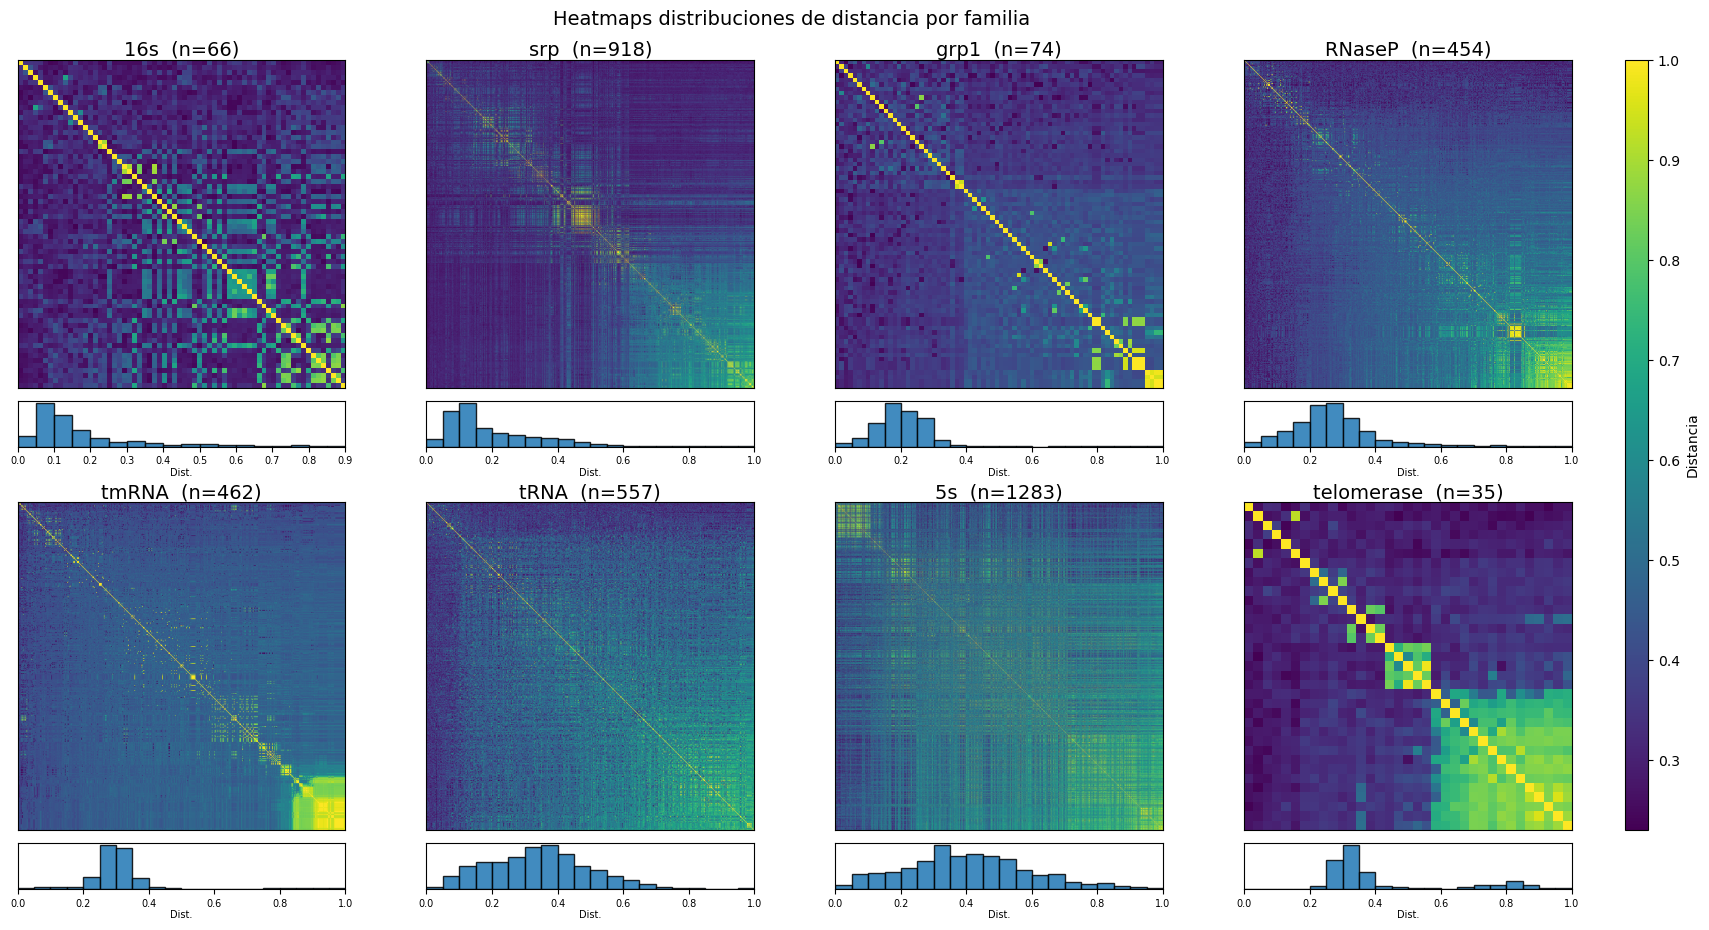

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

n_cols, n_rows = 4, 2
fig = plt.figure(figsize=(5 * n_cols + 1.4, 5 * n_rows))

gs = gridspec.GridSpec(
    n_rows,
    n_cols + 1,
    width_ratios=[1] * n_cols + [0.06],
    wspace=0.08,
    hspace=0.35,  # ↓ menor separación general
)

for idx, fam in enumerate(ordered_fams[:8]):
    ax = fig.add_subplot(gs[idx // n_cols, idx % n_cols])
    mat = order_by_mean_distance(corrs_filt[fam])

    im = ax.imshow(mat.values, cmap="viridis")
    ax.set_aspect("equal", adjustable="box")
    ax.set_title(f"{fam}  (n={mat.shape[0]})", fontsize=14, pad=0)  # ↓pad

    ax.set_xticks([])
    ax.set_yticks([])

    # -------- histograma más pegado y más bajo ----------
    vals = mat.values[np.triu_indices_from(mat, k=1)]
    bins = np.arange(0, vals.max() + 0.05, 0.05) if vals.size else [0, 1]

    ax_hist = ax.inset_axes([0.0, -0.18, 1.0, 0.14])  # y = −0.18, h = 0.14
    ax_hist.hist(vals, bins=bins, density=True, edgecolor="black", alpha=0.85)
    ax_hist.set_xlim(0, bins[-1])
    ax_hist.set_yticks([])
    ax_hist.set_xlabel("Dist.", fontsize=7, labelpad=1)
    ax_hist.tick_params(axis="x", labelsize=7)

# ----- paneles vacíos (si faltan familias) -------------------------------
for idx in range(len(plot_fams), n_rows * n_cols):
    fig.add_subplot(gs[idx // n_cols, idx % n_cols]).axis("off")

# ----- barra de color -----------------------------------------------------
cax = fig.add_subplot(gs[:, -1])
fig.colorbar(last_im, cax=cax, label="Distancia")

fig.suptitle("Heatmaps distribuciones de distancia por familia", y=0.93, fontsize=14)
plt.tight_layout(rect=[0, 0, 0.96, 0.90])
plt.show()